In [204]:
import sys,os
import lowpass
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import threading
import Queue
import time
from matplotlib import pyplot as plt
import math
import scipy

# Homomorphic Filtering

Homomorphic filtering is a generalized technique for signal and image processing, involving a nonlinear mapping to a different domain in which linear filter techniques are applied, followed by mapping back to the original domain. 
We have the following function which performs an homomorphic filter, as explained here:
https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
Which is a code adapted from here:
https://sites.google.com/site/bazeilst/tutorials#TUTO9

In [205]:

def homomorphic_filter(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img

    y_log = np.log(y+0.01)

    y_fft = np.fft.fft2(y_log)

    y_fft_shift = np.fft.fftshift(y_fft)

    DX = cols/cutoff
    G = np.ones((rows,cols))
    for i in range(rows):
        for j in range(cols):
            G[i][j]=((rh-rl)*(1-np.exp(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))))+rl
    result_filter = G * y_fft_shift

    result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter)))

    result = np.exp(result_interm)
    y = np.float32(result)

    return y

Below is the optimized code, which returns a similar result with much lower computational time and cost

In [206]:
def fast_homomorphic_filter(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img
    
    n = 100000.0
    y_log = n* (((y) ** (1/n)) - 1)

    
    # Check size for dft optimization
    nrows = cv2.getOptimalDFTSize(rows)
    ncols = cv2.getOptimalDFTSize(cols)

    nimg = np.zeros((nrows,ncols))
    nimg[:rows,:cols] = y_log
    # Do the DFT itself
    y_fft= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
    y_fft_shift = np.fft.fftshift(y_fft)


    DX = cols/cutoff

    F = []
    n = 100000.0
    F = [(-((i-nrows/2)**2+(j-ncols/2)**2)) for i in range (nrows) for j in range (ncols)]
    H = np.asarray(F,dtype=np.float64)/(2.0*DX**2)
    H = H/n
    H = (1-(1+H)**n)
    H = H*(rh-rl)
    H = H +rl
    H = np.reshape(H,(nrows,ncols))
    
    dft_complex = y_fft_shift[:,:,1] + y_fft_shift[:,:,0]*1j
    result_filter = H * dft_complex

    idft_flags = cv2.DFT_COMPLEX_OUTPUT| cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT
    
    result_split = np.ndarray(y_fft_shift.shape)
    result_split[:,:,0] = result_filter.imag
    result_split[:,:,1] = result_filter.real

    result_interm = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)

    result = np.exp(result_interm)
    y = np.float32(result[0:rows,0:cols])

    return y

# Homomorphic Filter Optimization

Now we are going to analyze the steps required by the homomorphic filter and see how can we optimize them.
To achieve this, we test the code step by step, proving different alternatives in each step and then checking the total error.

## Reading the image

No much more to say here.
We divide all the values by 255 so we have all the pixel values between 0 and 1.

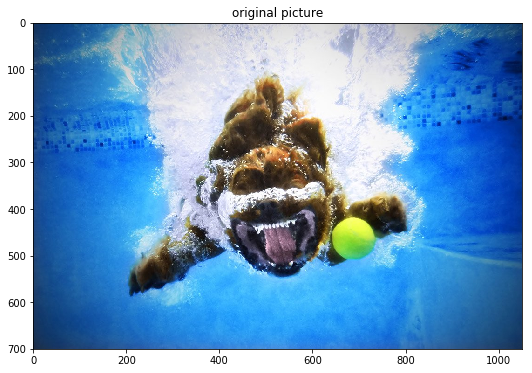

In [207]:
p = cv2.imread('dog.jpg',3)
RGB_im = np.float32(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))/255
plt.imshow(RGB_im)
plt.title('original picture')
plt.show()

Here we convert the values to float 32, so we have higher precision when performing the different operations later.
After that, we convert the image to YUV color enconding space. YUV stands for luma (Y) component and two chrominance (UV) components. The filter will be applied to the luma component, as we want to perform the corrections in the luminance.

In [208]:
img = np.float32(p)
img = img/255
        
img  = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

y = img[:, :, 0]
u = img[:, :, 1]
v = img[:, :, 2]

In [209]:
rows,cols = y.shape
rh, rl, cutoff = 2.5,0.5,32
rows,cols

(701, 1050)

Homomorphic filtering improves the image by simultaneous intensity range compression (illumination) and contrast enhancement (reflection).
The image is modelled according to:

$m(x,y) = i(x,y) \bullet r(x,y)$

Where:

m = image,
i = illumination,
r = reflectance.


We have to convert the image to the frequency domain in order to apply a high pass filter. In order to simplify the calculation, we use logarithms to have the product expressed as a sum:

$\ln(m(x,y)) = \ln(i(x,y)) + \ln(r(x,y))$

## Logarithm function

The logarithm of each pixel of the image is computed.
We can compute it with numpy, which is optimized for array operations, and math, which takes a single value and thus will require a for loop. Scipy also has the logarithm function, however it requires square matrix as input values.

We will compare the performance of each library with some custom approximations to the logarithm function.

### Numpy

In [210]:
%timeit y_log = np.log(y+0.01)

10 loops, best of 3: 19.5 ms per loop


### Math

In [211]:
%%%timeit
y_log2 = []
for el in y:
    for pix in el:
        y_log2.append(math.log(pix+0.01))

1 loop, best of 3: 2.62 s per loop


### Scipy

Requires square functions, we divide the img in squares

In [212]:
shape = y.shape
minval = np.amin(shape)
y_copy = y[0:minval,0:minval]
print y_copy.shape

(701, 701)


In [213]:
%timeit y_log3 = scipy.linalg.logm(y_copy)

logm result may be inaccurate, approximate err = 8.11954383935e-06
logm result may be inaccurate, approximate err = 8.11954383935e-06
logm result may be inaccurate, approximate err = 8.11954383935e-06
logm result may be inaccurate, approximate err = 8.11954383935e-06
1 loop, best of 3: 10.6 s per loop


As we have seen, numpy is the faster library for logarithm computation of an array, as it is optimized for that purpose. We will see however if we can do an approximation to the logarithm, which performs a faster computation with a small error

### Taylor Series approximation

Taylor series is a representation of a function as an infinite sum of terms that are calculated from the values of the function's derivatives at a single point.
The Taylor Serie of the natural logarithm used here is:

$ln(x) = \sum^\infty_{n=1} \frac{(-1)^{n+1}}{n}(x-1)^n  \cong (x-1) - \frac{(x-1)^2}{2} - \frac{(x-1)^3}{3} - ...$


For $|x|<1$. Firt we check that we accomplish that condition:

In [214]:
print np.amax(y)

1.0


In [215]:
%%%timeit
x = y+0.01
log = (x-1) - (x-1)**2/2 + (x-1)**3/3

10 loops, best of 3: 66.8 ms per loop


As we can see it is quite slow. Lets check error however:

In [216]:
y_log = np.log(y+0.01)

x = y+0.01
log = (x-1) - (x-1)**2/2 + (x-1)**3/3

A = log
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

mean squared error = 0.0263182
error percentage = 1.48430622366 %


We have a bad performance as the algorithm is slow and the error is high.

### Limit Approximation

The logarithm function can be expressed as a limit according to:


$ \ln(x) = \lim\limits_{n \to \infty}n(x^{1/n}-1)$

In [217]:
def lnlm(x):
    n = 10000.0
    x = np.asarray(x)
    return n * ((x ** (1/n)) - 1)

In [218]:
%%%timeit
n = 10000
limlog = n* ((y ** (1/n)) - 1)

The slowest run took 5.70 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.15 ms per loop


In [219]:
y_log = np.log(y+0.01)

limlog = lnlm(y+0.01)

print y_log[100][100]
print limlog[100][100]

A = limlog
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

-1.04603
-1.04606
mean squared error = 3.45809e-08
error percentage = 8.87383248471e-07 %


In [220]:
# time comparison
limtime   = 781.0*10**(-3) #ms
numpytime = 15.2

print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 94.8618421053 %


As we can see the error is as small as a 8.87383e-09 %, and the time performance is increased by a 95%, making the limit approximation the best option for logarithm computing

## Fourier transform

Up to this point we have the image expressed as a logarithm.

$\ln(m(x,y)) = \ln(i(x,y)) + \ln(r(x,y))$

Now we want to express it on the frequency domain, for what we will apply the Fourier transform:

$\mathcal{F}(\ln(m(x,y))) = \mathcal{F}(\ln(i(x,y))) + \mathcal{F}(\ln(r(x,y)))$

which is also expressed as:

$M(u,v) = I(u,v) + R(u,v)$

Help with this in https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
theory http://www.lip.uns.edu.ar/pdi/32.htm

We have two libraries which we can use to compute the 2D Fourier Transform: Numpy and OpenCV. Both compute this transform with a fast algorithm called Fast Fourier Transform (FFT). Both libraries return the result with the zero frequency component at the top left component, which can be brought to center with the numpy function fftshift. The magnitude spectrum will be drawn in both cases to see the similarity between both results.

### Without DFT Optimization

The DFT is optimized for array sizes which are power of two, for what we can resize the image to accomplish this requirement. We first perform the calculation with both libraries without the optimization, and then with the optimization to compare results.

#### Numpy

In [221]:
%%%timeit
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

1 loop, best of 3: 1.35 s per loop


In [222]:
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

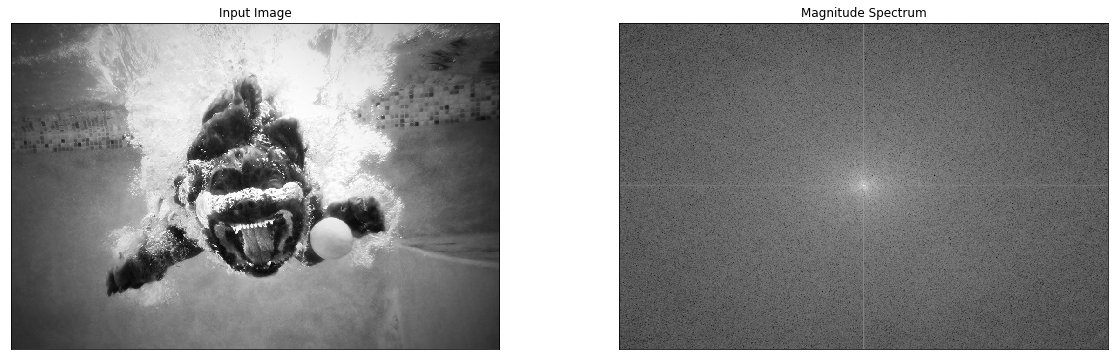

In [223]:
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

##### OpenCV

In [224]:
%%%timeit
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

10 loops, best of 3: 19.2 ms per loop


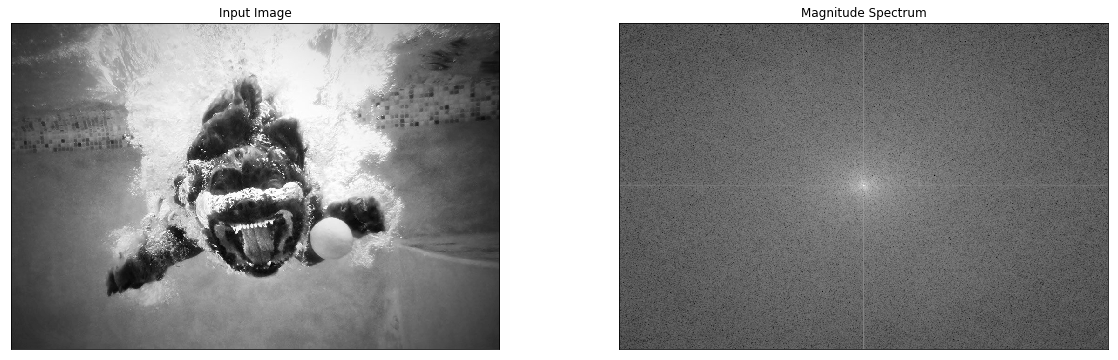

In [225]:
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum2 = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum2, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

error

In [226]:
A = magnitude_spectrum
print A.shape
B = magnitude_spectrum2
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(701, 1050)
(701, 1050)
56.9888390251
56.9888
mean squared error = 1.90721895748e-08
error percentage = 3.64882340317e-08 %


As we can see the result is basically the same, with OpenCV being much more faster. Let's see how much the optimization improves the time performance.

### With DFT optimization

First, obtain optimal size of the image, and then generate a new image with this size where we fill the extra pixels with zero values.

In [227]:
rows,cols = limlog.shape
print rows,cols

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print nrows, ncols

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

701 1050
720 1080


##### Numpy

In [228]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

1 loop, best of 3: 128 ms per loop


In [229]:
fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

##### OpenCV

In [230]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

10 loops, best of 3: 40.3 ms per loop


In [231]:
dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

In [232]:
A = magnitude_spectrum4
print A.shape
B = magnitude_spectrum3
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(720, 1080)
(720, 1080)
44.1247112264
44.1247
mean squared error = 1.41734057405e-08
error percentage = 2.17559703822e-08 %


In [233]:
# time comparison
opencvtime   = 29.9 #ms
numpytime    = 793
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 99.9015132409 %


Numpy and OpenCV return basically the same value, as the error is very small. However, the performance of OpenCV with the optimization is significativally better than that of numpy (without optimization)

### High pass filter

Now that we have the image in the frequency domain, the next step is to apply the high pass filter. To make the illumination of an image more even, the high-frequency components are increased and low-frequency components are decreased. 

$N(u,v) = H(u,v) \bullet M(u,v)$

Where

H = High-pass filter,
N = Filtered image in the frequency domain.

#### Custom High Pass filter

This filter decreases the contribution of the low frequencies (illumination) and amplifies the contribution of mid and high frequencies (reflectance), sharpening the edges in the image, as seen in "Automatic Underwater Image Pre-Processing" by Stéphane Bazeille et al.

$H(u,v) = (r_H-r_L)(1-\exp(-\frac{u^2+v^2}{2\delta^2}))+r_L$

where $r_H = 2.5$ and $r_L=0.5$ are the maximum and minimum coefficients values and $\delta$ a factor which controls the cutoff frequency. They are selected empirically.

In [234]:
DX = ncols/cutoff
G = np.ones((nrows,ncols))

##### Numpy

This is what the most "intuitive" function to generate the filter takes.
We first focus on the exponential function. Numpy has a function which computes the exponential, but the built-in operations on arrays from numpy also allow to do the operation "manually". Let's check both options:

In [235]:
%%%timeit
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=((rh-rl)*(1-np.exp(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))))+rl

result_filter = G * fshift2

1 loop, best of 3: 4.66 s per loop


In [236]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 1.74 s per loop


#### Taylor Approximation

The taylor series of the exponential function converges for all x, and is expressed as:


$e^x = \sum^{\infty}_{n=0}\frac{x^n}{n!} = 1 + x + \frac{x^2}{2!}+ \frac{x^3}{3!}$

In [237]:
def exp_taylor(x):
    return 1+x+x**2/2+x**3/3+x**4/24+x**5/120+x**6/720+x**7/5040

print np.e**5
print exp_taylor(5)

148.413159103
147


In [238]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_taylor(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 2.93 s per loop


Due to this high error, we discard the Taylor series for exponential function approximation. It is also slower than the numpy function.

##### Limit Approximation

The exponential function can be obtaind as the limit of a sequence according to:
$ e^x = \lim\limits_{n \to \infty} (1+\frac{x}{n})^n $

In [239]:
def exp_lim(x):
    n = 10000
    return (1+x/n)**n

print np.e**5
print exp_lim(5.0)

148.413159103
148.227820292


In [240]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_lim(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 1.67 s per loop


##### Code Optimization

Since there is no use of libraries here, the only option to improve the performance is to optimize the code.

In [241]:
%%%timeit
G = []
G = [(i,j) for i in range (nrows) for j in range (ncols)]
H = map(lambda x: exp_lim(-(x[0]**2+x[1]**2)/(2*DX**2)), G)
H = 1-np.asarray(H)
H = H*(rh-rl)
H = H +rl

1 loop, best of 3: 1.16 s per loop


Here we use list comprehension, which is the fastest iteration tool that Python provides:

In [242]:
%%%timeit
G = []
G = [exp_lim(-(i**2+j**2)/(2*DX**2)) for i in range (nrows) for j in range (ncols)]
H = 1-np.asarray(G)
H = H*(rh-rl)
H = H +rl

1 loop, best of 3: 954 ms per loop


We have also experimentally seen that the more operations we take out of the loop, the faster the algorithm.
Also, if we perform all the operations in the same line command instead of calling a function, the computation time decreases significativally:

In [243]:
%%%timeit
G = []
n = 10000
G = [(-(i**2+j**2)) for i in range (nrows) for j in range (ncols)]
H = np.asarray(G)/(2*DX**2)
H = H/n
H = (1-(1+H)**n)
H = H*(rh-rl)
H = H +rl
H = np.reshape(H,(nrows,ncols))

1 loop, best of 3: 509 ms per loop


In resume, and as seen here (https://medium.freecodecamp.org/if-you-have-slow-loops-in-python-you-can-fix-it-until-you-cant-3a39e03b6f35):
   - Do numerical calculations with NumPy functions. They are two orders of magnitude faster than Python’s built-in tools.
   - Of Python’s built-in tools, list comprehension is faster than map() , which is significantly faster than for.
   - For deeply recursive algorithms, loops are more efficient than recursive function calls.
   - “Dumb” code (broken down into elementary operations) is the slowest. Use built-in functions and tools.


In [244]:
G = np.ones((nrows,ncols))
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G*(rh-rl)
G = G +rl

A = G

F = []
n = 100000.0
F = [(-((i-nrows/2)**2+(j-ncols/2)**2)) for i in range (nrows) for j in range (ncols)]
H = np.asarray(F,dtype=np.float64)/(2.0*DX**2)
H = H/n
H = (1-(1+H)**n)
H = H*(rh-rl)
H = H +rl
H = np.reshape(H,(nrows,ncols))



print A.shape
B = H
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(720, 1080)
(720, 1080)
2.5
2.5
mean squared error = 0.00417322436689
error percentage = 0.834644873378 %


In [245]:
print fshift2[700][200]
print G[700][200]
print H[700][200]
result_filter1 = G * fshift2

result_filter2 = H * fshift2

A = result_filter1
print A.shape
B = result_filter2
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(23.1873161445-1.35400464963j)
2.5
2.5
(720, 1080)
(720, 1080)
(57.9682903612-3.38501162407j)
(57.9682903612-3.38501162407j)
mean squared error = (84122.1379305-6.36842822338e-10j)
error percentage = (29.9132180683-2.26456658003e-13j) %


In [246]:
# time comparison
opttime   = 3.26*10**3 #ms
numpytime    = 418
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 99.8131578947 %


#### With OpenCV array

I perform the same operations but with the Fourier transform obained from the OpenCV functions. I need to convert the two-channel opencv array to one-channel with complex numbers

In [247]:
dft_complex = dft_shift2[:,:,1] + dft_shift2[:,:,0]*1j

In [248]:
%timeit dft_complex = dft_shift2[:,:,1] + dft_shift2[:,:,0]*1j

100 loops, best of 3: 5.62 ms per loop


In [249]:
A = fshift2
B = dft_complex


print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

(23.1873161445-1.35400464963j)
(23.1873-1.35402j)
mean squared error = (4.07877685172e-10-8.02003605754e-11j)
error percentage = (7.25191634562e-14-1.42593313369e-14j) %


In [250]:
print G[700][200]
print H[700][200]
result_filter3 = G * dft_complex

result_filter4 = H * dft_complex

A = result_filter2
print A.shape
B = result_filter4
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
print 'mean squared error =',mse
print 'error percentage =',(100*mse)/np.abs(np.amin(A)),'%'

2.5
2.5
(720, 1080)
(720, 1080)
(57.9682903612-3.38501162407j)
(57.96833992-3.3850479126j)
mean squared error = (1.17244443805e-09-5.19936676523e-10j)
error percentage = (4.16912682097e-13-1.84885686088e-13j) %


#### Simple High pass filter

Here we will simply suppress all the lower frequencies.They are allocated in the center, so we can simply turn the first elements of the matrix to zero. The size of the window is selected manually.

In [251]:
%%%timeit
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-15:crow+15, ccol-15:ccol+15,0] = 0
dft_shift2_copy[crow-15:crow+15, ccol-30:ccol+15,1] = 0

The slowest run took 4.71 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.24 ms per loop


In [252]:
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-2:crow+2, ccol-2:ccol+2,0] = 0
dft_shift2_copy[crow-2:crow+2, ccol-2:ccol+2,1] = 0

## Inverse Fourier Transform

Once the filter is applied, we return back to the spatial domain by using a inverse Fourier transform.

$n(x,y) = inv\mathcal{F}(N(u,v))$

### Numpy

In [253]:
%timeit result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter4)))

10 loops, best of 3: 57.9 ms per loop


In [254]:
result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter4)))


### OpenCV

According to OpenCV documentation on the cv2.idft function: http://docs.opencv.org/modules/core/doc/operations_on_arrays.html#idft . There is a note at the end of it, which says:

    Note: None of dft and idft scales the result by default. So, you should pass DFT_SCALE to one of dft or idft explicitly to make these transforms mutually inverse.

So, when calling idft, it is necessary to pass the cv2.DFT_SCALE flag. 

In [255]:
idft_flags = cv2.DFT_COMPLEX_OUTPUT| cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT

In [256]:
%%%timeit
result_split = np.ndarray(dft_shift2.shape)
result_split[:,:,0] = result_filter4.imag
result_split[:,:,1] = result_filter4.real

result_interm2 = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)

10 loops, best of 3: 23.4 ms per loop


In [257]:
result_split = np.ndarray(dft_shift2.shape)
result_split[:,:,0] = result_filter4.imag
result_split[:,:,1] = result_filter4.real

result_interm2 = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)

In [258]:
A = result_interm
print A.shape
B = result_interm2
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(720, 1080)
(720, 1080)
-1.52856842578
-1.52856842578


9.2440583064339127e-31

In [259]:
# time comparison
opcvtime   = 29.7 #ms
numpytime    = 40.1
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 98.0523690773 %


### OpenCV + Simple HPF

In [260]:
result_interm3 = cv2.idft(np.fft.ifftshift(dft_shift2_copy),flags = idft_flags)

## Reverse Logarithm Transform with exponential

The last step is to eliminate the logarithm with the exponential to finally obtain the enhanced image.

### Numpy

In [261]:
%timeit result = np.exp(result_interm2)

10 loops, best of 3: 32.4 ms per loop


### Limit approximation

In [262]:
%timeit result2 = exp_lim(result_interm2)

10 loops, best of 3: 64.2 ms per loop


In [263]:
result = np.exp(result_interm2)

In [264]:
result2 = exp_lim(result_interm2)

In [265]:
A = result
print A.shape
B = result2
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(720, 1080)
(720, 1080)
0.216845876185
0.216820541831


6.7568999353278476e-09

Here the best option is to use the built-in numpy function as it is the fastest.

In [266]:
j = result[0:rows,0:cols]

Populating the interactive namespace from numpy and matplotlib


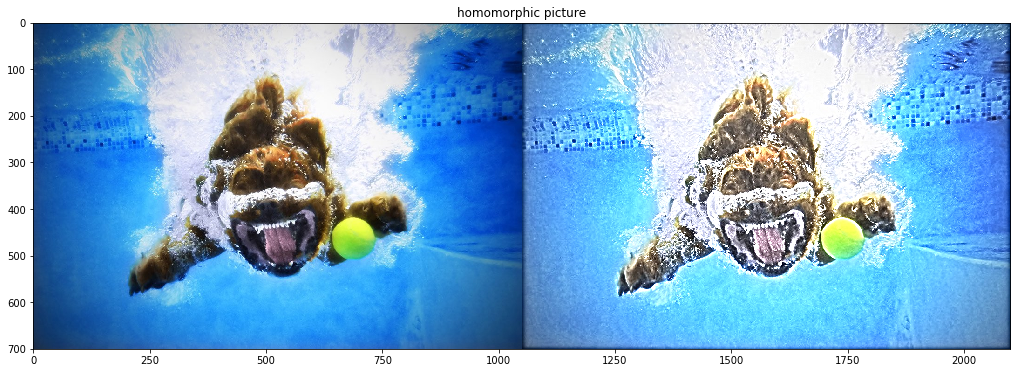

In [267]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

merged = cv2.merge((np.float32(j),u,v))
imgf  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

#### Custom Simply HPF

In [268]:
%timeit result2 = np.exp(result_interm3)

10 loops, best of 3: 23 ms per loop


In [269]:
result3 = np.exp(result_interm3)
#k = np.float32(result2)
k_original_size = result3[0:rows,0:cols]
k_original_size.shape

(701, 1050)

Populating the interactive namespace from numpy and matplotlib


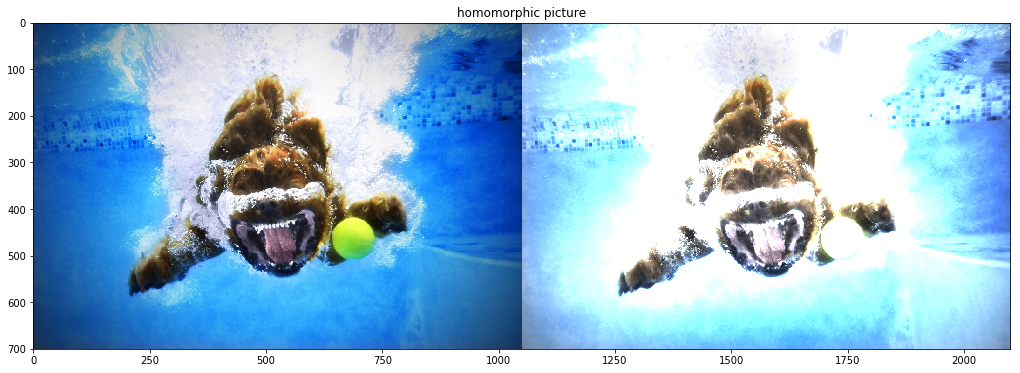

In [270]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

merged2 = cv2.merge((k_original_size,u,v))
imgf2  = cv2.cvtColor(merged2,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

In [271]:
%%%timeit
otra = homomorphic_filter(y)

1 loop, best of 3: 5.69 s per loop


In [272]:
%%%timeit
otra = fast_homomorphic_filter(y)

1 loop, best of 3: 819 ms per loop


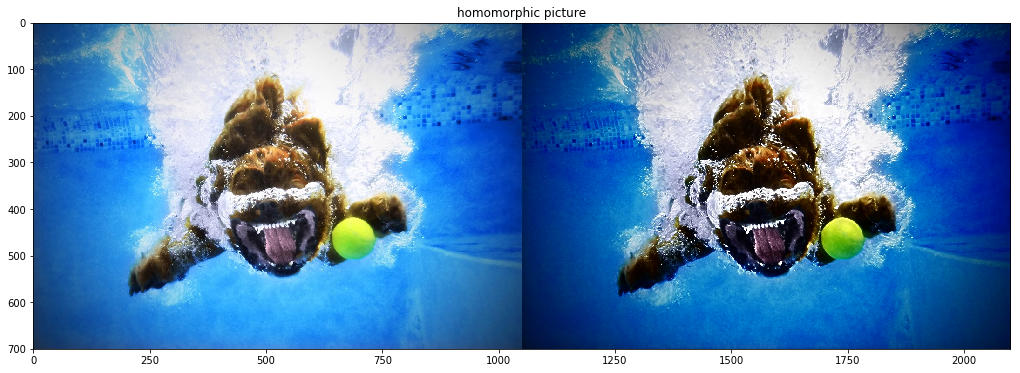

In [273]:
otra = homomorphic_filter(y)
merged = cv2.merge((otra,u,v))
imgf2  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

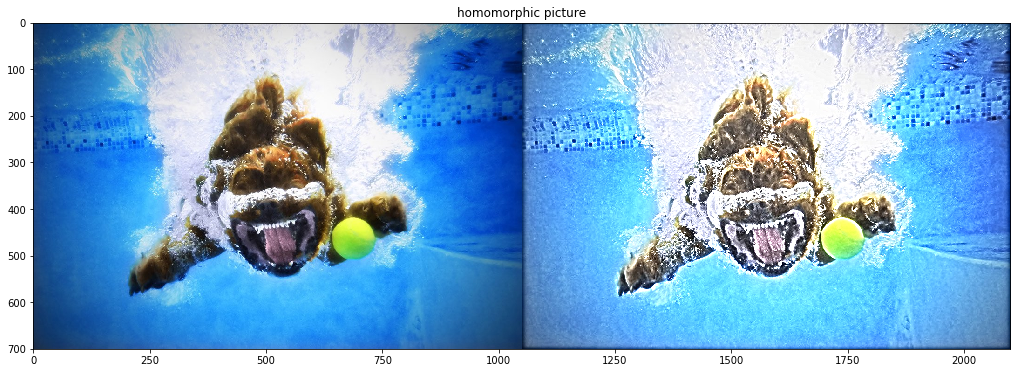

In [274]:
otra = fast_homomorphic_filter(y)
merged = cv2.merge((otra,u,v))
imgf2  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

In [275]:
# time comparison
opttime   = 4.11*10**3 #ms
oldtime    = 652
print 'performance improvement =', (100*(1-limtime/numpytime)),'%'

performance improvement = 98.0523690773 %
